# Predicting Red Hat Business Value
## Background
Like most companies, Red Hat is able to gather a great deal of information over time about the behavior of individuals who interact with them. They’re in search of better methods of using this behavioral data to predict which individuals they should approach—and even when and how to approach them.

In this project, we are challenged to create a classification algorithm that accurately identifies which customers have the most potential business value for Red Hat based on their characteristics and activities.

With an improved prediction model in place, Red Hat will be able to more efficiently prioritize resources to generate more business and better serve their customers.

## Data reshaping and exploration
### Background settings

In [46]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib as mt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler,LabelEncoder, OneHotEncoder

from datetime import datetime

from sklearn.cross_validation import StratifiedShuffleSplit, KFold

from scipy.sparse import hstack, vstack, coo_matrix
from scipy.stats import chi2_contingency,ttest_ind

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, accuracy_score

from sklearn import grid_search
from sklearn.grid_search import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import Lasso

### Description
The next several chunks will read and describe basic information of these datasets.

In [3]:
#read datasets
raw_train = pd.read_csv("act_train.csv")
raw_people = pd.read_csv("people.csv")
raw_test = pd.read_csv("act_test.csv")

#randomly select 2% samples to test code
raw_train_sample = raw_train.sample(frac = 0.02)
raw_people_sample = raw_people.sample(frac = 0.1)

In [4]:
#number of act_train samples
n_act_sample = len(raw_train)

#number of act_train columns
n_act_col = len(raw_train.columns)

#number of people columns
n_people_col = len(raw_people.columns)

#number of samples with 1 outcome in raw_train
n_outcome_1 = len(raw_train[raw_train.outcome == 1])

#number of samples with 0 outcome in raw_train
n_outcome_0 = len(raw_train[raw_train.outcome == 0])

print "Total number of act_train samples: {}".format(n_act_sample)
print "Total number of act_train columns: {}".format(n_act_col)
print "Total number of people columns: {}".format(n_people_col)
print "Total number of samples with 1 outcome in raw_train: {}".format(n_outcome_1)
print "Total number of samples with 0 outcome in raw_train: {}".format(n_outcome_0)


del n_act_sample
del n_act_col
del n_people_col
del n_outcome_1
del n_outcome_0

Total number of act_train samples: 2197291
Total number of act_train columns: 15
Total number of people columns: 41
Total number of samples with 1 outcome in raw_train: 975497
Total number of samples with 0 outcome in raw_train: 1221794


In [4]:
#see types of raw_train variables
raw_train.dtypes

people_id            object
activity_id          object
date                 object
activity_category    object
char_1               object
char_2               object
char_3               object
char_4               object
char_5               object
char_6               object
char_7               object
char_8               object
char_9               object
char_10              object
outcome               int64
dtype: object

In [5]:
#see types of raw_people variables
raw_people.dtypes

people_id    object
char_1       object
group_1      object
char_2       object
date         object
char_3       object
char_4       object
char_5       object
char_6       object
char_7       object
char_8       object
char_9       object
char_10        bool
char_11        bool
char_12        bool
char_13        bool
char_14        bool
char_15        bool
char_16        bool
char_17        bool
char_18        bool
char_19        bool
char_20        bool
char_21        bool
char_22        bool
char_23        bool
char_24        bool
char_25        bool
char_26        bool
char_27        bool
char_28        bool
char_29        bool
char_30        bool
char_31        bool
char_32        bool
char_33        bool
char_34        bool
char_35        bool
char_36        bool
char_37        bool
char_38       int64
dtype: object

As we can see, act_train dataset has over 2 million samples, with 15 variables, including the classification outcome. The act_train and people data set have the same variable, people_id, so that we could merge them in later analysis. In act_train.csv, most variables are object type. In people.csv, there are 29 boolean variables, 10 object variable and 1 date, except people_id. Also I notice that distribution of outcome is not too much uneven, since 44% outcome are 1. So next I am gonna see distributions of each variable and their relationships with outcome. 

### Exploratory analysis
In next chunks, I will try to dig into each variable.

- activity_category in act_train

In [6]:
raw_train.activity_category.describe()

count     2197291
unique          7
top        type 2
freq       904683
Name: activity_category, dtype: object

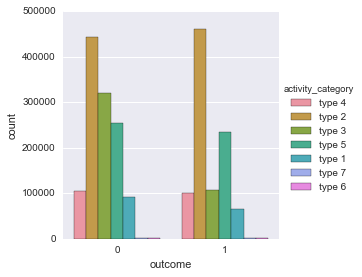

In [7]:
s#plot activity category vs ourcome
%matplotlib inline
import seaborn as sns
sns.factorplot("outcome", hue="activity_category", data=raw_train, kind="count")

From the graph above, there are 7 different types in activity_category, among which portions of type 3 and type 5 are quite different visually with respect to 0 and 1 outcome. No NAs. 

- char_1 .... char_10 in act_train

Let's name char_1.....char_10 char_train as a whole. The first 9 variables works synchronously, as they have NAs and valid values in exactly same positions. Since over 90% data are not available, analyzing each of them does not make sense. Also I found that if char_train are NAs, char_10 has a valid value and vice versa. 

I created a new variable, na_flag, representing whether char_train is 0 or not. Then I am gonna see the outcome distribution in each group. 

In [9]:
#how many NAs in char_1 to char_10 in act_train
for i in range(10):
    char_name = "char_" + str(i+1)
    n_na = len(raw_train[raw_train[char_name].isnull()])
    print "char_{} has {} NAs".format(i+1,n_na)

del n_na, char_name

char_1 has 2039676 NAs
char_2 has 2039676 NAs
char_3 has 2039676 NAs
char_4 has 2039676 NAs
char_5 has 2039676 NAs
char_6 has 2039676 NAs
char_7 has 2039676 NAs
char_8 has 2039676 NAs
char_9 has 2039676 NAs
char_10 has 157615 NAs


In [5]:
#create a new variable representing whether char_1 is null or not
raw_train['na_flag'] = (~raw_train.char_1.isnull())+0
raw_test['na_flag'] = (~raw_test.char_1.isnull())+0

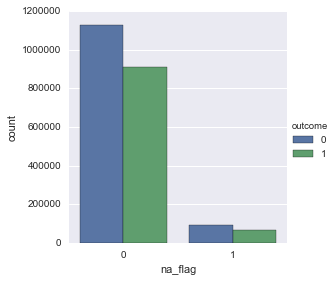

In [11]:
sns.factorplot("na_flag", hue="outcome", data=raw_train, kind="count")

It seems that there is no distinctive difference between na_flag 0 and 1. But I would like to use chi-square to test my hypothesis. 

In [45]:
#chi2_test for na_flag and outcome
pivot = pd.pivot_table(data = raw_train[['na_flag', 'outcome']], index = 'outcome', columns = ['na_flag'], aggfunc = len)
pivot
chi2, p_value, dof, expected = chi2_contingency(pivot)
print pivot,'\n'
print "Does na_flag have a significant effect on outcome?"
print "chi_score = "+str(chi2)
print "p-value = "+str(p_value)

na_flag        0      1
outcome                
0        1129010  92784
1         910666  64831 

Does na_flag have a significant effect on outcome?
chi_score = 732.161839439
p-value = 3.03474354958e-161


Since p-value of the chi-square test is extremely close to 0, we conclude that outcome distribution between 2 na_flag groups are quite different. 

- date in both act_train.csv and people.csv

The real values of date in both data sets do not make sense as the date values have all been shifted by same distance. So I consider to change them into relative values, that is, convert each date value into day difference between itself and a baseline date. I choose 2022-01-01 as the baseline date. New variable names are date_train and date_people, respectively.

In later analysis, I will rescale them so it does not matter what the baseline date is as long as the day differences are positive. 

In [6]:
#transform string into date format
#baseline is the base date
#element is the data list
#for date in act_train.csv
def time_diff(baseline, element):
    baseline_date = datetime.strptime(baseline,'%Y-%m-%d')
    day_diff = []
    for ele in element:
        date_object = datetime.strptime(ele,'%Y-%m-%d')
        date_diff = (date_object-baseline_date).days
        day_diff.append(date_diff)
        
    return day_diff

date_time_train = time_diff('2022-01-01',raw_train.date)
date_time_people = time_diff('2020-01-01', raw_people.date)

In [7]:
#for date in people.csv
def time_diff2(baseline, element):
    baseline_date = datetime.strptime(baseline,'%Y-%m-%d')
    day_diff = []
    for ele in element:
        date_object = datetime.strptime(ele,'%m/%d/%Y')
        date_diff = (date_object-baseline_date).days
        day_diff.append(date_diff)
        
    return day_diff
date_time_test = time_diff2('2022-01-01', raw_test.date)

In [8]:
#add day differences into a new variable.
raw_train['date_train'] = date_time_train
raw_people['date_people'] = date_time_people
raw_test['date_train'] = date_time_test
del date_time_train
del date_time_people
del date_time_test

Now, I would like to see date distributions acorss outcome, respevtively. Notice that we should merge act_train.csv and people.csv in order to dig in date of people.csv.

C:\Users\fretwan\Anaconda2\lib\site-packages\seaborn\categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


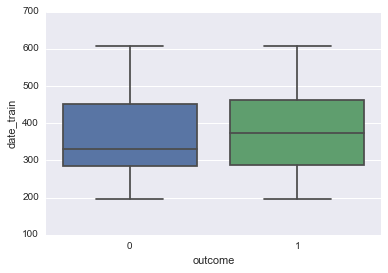

In [49]:
#see day differences distribution with respect to date_train
sns.boxplot(raw_train.date_train, groupby = raw_train.outcome)

In [9]:
#merge two datasets
raw_merge = raw_train.merge(raw_people, on = 'people_id')
test_merge = raw_test.merge(raw_people, on = 'people_id')

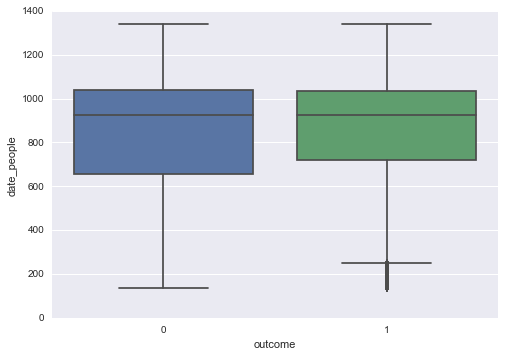

In [33]:
#see day differences distribution across outcome with respect to date_people
sns.boxplot(raw_merge.date_people, groupby = raw_merge.outcome)

See that means of date_train are quite different and means of date_people are similar between two groups. Assume that day difference follows normal distribution, do t-test to see if day differences are different between two groups.

In [57]:
a = raw_merge['date_train'][raw_merge.outcome == 0]
b = raw_merge['date_train'][raw_merge.outcome == 1]
c = raw_merge['date_people'][raw_merge.outcome == 0]
d = raw_merge['date_people'][raw_merge.outcome == 1]

t1, p1 = ttest_ind(a, b, equal_var = False)
t2, p2 = ttest_ind(c, d, equal_var = False)
print "t-statistic for date_train is"+str(t1)
print "p-value for date_train across outcome is"+str(p1)
print "t-statistic for date_people is"+str(t2)
print "p-value for date_people across outcome is"+str(p2)

del a,b,c,d,t1,p1,t2,p2

t-statistic for date_train is-77.5066661402
p-value for date_train across outcome is0.0
t-statistic for date_people is-53.7061926198
p-value for date_people across outcome is0.0


T-test results support that means of date_train and date_people across outcome are both significantly different at 1% level since p-values are almost 0.

In [34]:
#see raw_merge's columns for following analysis.
raw_merge.columns

Index([u'people_id', u'activity_id', u'date_x', u'activity_category',
       u'char_1_x', u'char_2_x', u'char_3_x', u'char_4_x', u'char_5_x',
       u'char_6_x', u'char_7_x', u'char_8_x', u'char_9_x', u'char_10_x',
       u'outcome', u'date_train', u'na_flag', u'char_1_y', u'group_1',
       u'char_2_y', u'date_y', u'char_3_y', u'char_4_y', u'char_5_y',
       u'char_6_y', u'char_7_y', u'char_8_y', u'char_9_y', u'char_10_y',
       u'char_11', u'char_12', u'char_13', u'char_14', u'char_15', u'char_16',
       u'char_17', u'char_18', u'char_19', u'char_20', u'char_21', u'char_22',
       u'char_23', u'char_24', u'char_25', u'char_26', u'char_27', u'char_28',
       u'char_29', u'char_30', u'char_31', u'char_32', u'char_33', u'char_34',
       u'char_35', u'char_36', u'char_37', u'char_38', u'date_people'],
      dtype='object')

- group_1

The group_1 is an object variable. Firstly we see some basic information regarding it.

In [58]:
raw_merge.group_1.describe()

count         2197291
unique          29899
top       group 17304
freq           799125
Name: group_1, dtype: object

The group_1 has nearly 30 thousand unique values, which is a really big number. Among thousands of types of value, group_17304 takes up almost 40% of total samples. However, I would like to know if group_17304, the second greatest one or along with several following types could dominate the ditribution. 

In [61]:
group_1_count = {}
count = 0
for item in list(set(raw_merge.group_1)):
    num = sum((raw_merge.group_1 == item)+0)
    group_1_count[item] = num
    count += num
    if (count/2197291)>0.95:
        group_1_count['other'] = 2197291 - count
        break;
        

In [65]:
#See the number of each value
for key, value in sorted(group_1_count.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %s" % (key, value)

other: 0
group 10001: 1
group 10002: 1
group 10013: 1
group 10100: 1
group 10122: 1
group 10130: 1
group 1014: 1
group 10144: 1
group 10152: 1
group 10175: 1
group 10195: 1
group 10249: 1
group 10276: 1
group 10282: 1
group 10309: 1
group 10318: 1
group 10322: 1
group 10323: 1
group 10324: 1
group 10358: 1
group 10379: 1
group 10389: 1
group 10473: 1
group 10505: 1
group 1051: 1
group 10529: 1
group 10543: 1
group 10577: 1
group 10584: 1
group 10819: 1
group 10891: 1
group 10915: 1
group 10920: 1
group 10958: 1
group 10989: 1
group 11048: 1
group 11101: 1
group 11142: 1
group 11157: 1
group 11164: 1
group 11166: 1
group 11208: 1
group 11215: 1
group 11238: 1
group 11255: 1
group 11269: 1
group 11270: 1
group 113: 1
group 11323: 1
group 11363: 1
group 11410: 1
group 11429: 1
group 11444: 1
group 11459: 1
group 11460: 1
group 11463: 1
group 11485: 1
group 11487: 1
group 11501: 1
group 11504: 1
group 11505: 1
group 11518: 1
group 11528: 1
group 11541: 1
group 11545: 1
group 11561: 1
group

We can clearly see that the ones with the second, the third and other following greatest count number are much less than group_17304, so only couples of types cannot dominate the distribution.  

I am interested in outcome distribution across a couple of types.

In [83]:
#see the outcome distribution within group 17304, 27940 and 667
merge_group_17304 = raw_merge[(raw_merge['group_1'] == 'group 17304')|(raw_merge['group_1'] == 'group 27940')|(raw_merge['group_1'] == 'group 667')]

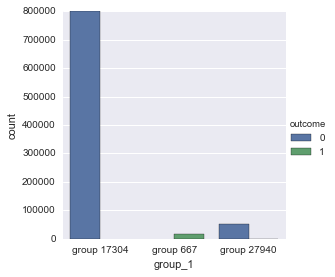

In [86]:
#group_1 and outcome
sns.factorplot("group_1", hue="outcome", data=merge_group_17304, kind="count")
del merge_group_17304

Surprisingly, group_17304 samples all have 0 outcomes. Meanwhile, at least for the three types showed with the greatest count number, they each has a dominating outcome value. For example, most outcomes of group_667 samples are 1 while most of gourp_27940 are 0. It would cause data leakage but I will not utilize the leakage in my prediction.

- char_1_y.....char_9_y

I call char_1_y to char_9_y as a whole char_y_one. The 9 variables are object type, and it is easy to see outcome distribution acorss them. From following description, we could find something in common. Firstly, they do not have any NA. Secondly, the number of unique value type is limited. Thirdly, we could visually see that outcome distributions are not the same among different types. 

In [87]:
raw_merge.char_1_y.describe()

count     2197291
unique          2
top        type 2
freq      1991452
Name: char_1_y, dtype: object

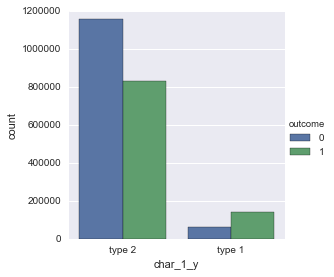

In [88]:
#char_1_y and outcome
sns.factorplot("char_1_y", hue="outcome", data=raw_merge, kind="count")

In [89]:
raw_merge.char_2_y.describe()

count     2197291
unique          3
top        type 3
freq      1192327
Name: char_2_y, dtype: object

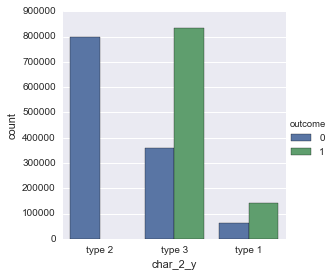

In [90]:
#char_2_y and outcome
sns.factorplot("char_2_y", hue="outcome", data=raw_merge, kind="count")

In [91]:
raw_merge.char_3_y.describe()

count     2197291
unique         43
top       type 40
freq       697260
Name: char_3_y, dtype: object

In [93]:
raw_merge.char_4_y.describe()

count     2197291
unique         25
top       type 25
freq       697260
Name: char_4_y, dtype: object

In [94]:
raw_merge.char_5_y.describe()

count     2197291
unique          9
top        type 9
freq       697260
Name: char_5_y, dtype: object

In [95]:
raw_merge.char_6_y.describe()

count     2197291
unique          7
top        type 1
freq       723095
Name: char_6_y, dtype: object

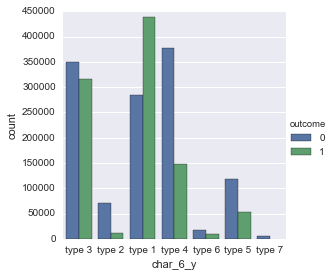

In [96]:
#char_6_y and outcome
sns.factorplot("char_6_y", hue="outcome", data=raw_merge, kind="count")

In [97]:
raw_merge.char_7_y.describe()

count     2197291
unique         25
top        type 8
freq       263444
Name: char_7_y, dtype: object

In [98]:
raw_merge.char_8_y.describe()

count     2197291
unique          8
top        type 3
freq       925643
Name: char_8_y, dtype: object

In [99]:
raw_merge.char_9_y.describe()

count     2197291
unique          9
top        type 3
freq       972575
Name: char_9_y, dtype: object

- char_10_y.......to char_37_y

I name char_10_y....to char_37_y as a whole char_y_2. They are all boolean variables, and false groups have more 0 than 1 while true groups have more 1 than 0. Since it would be too long and redundant, I will not show you the entire descriptions.

In [100]:
raw_merge.char_10_y.describe()

count     2197291
unique          2
top         False
freq      1667159
Name: char_10_y, dtype: object

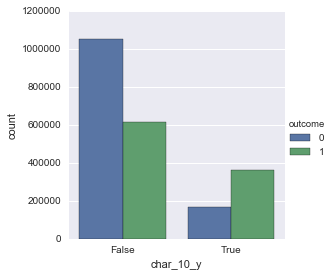

In [101]:
#char_10_y and outcome
sns.factorplot("char_10_y", hue="outcome", data=raw_merge, kind="count")

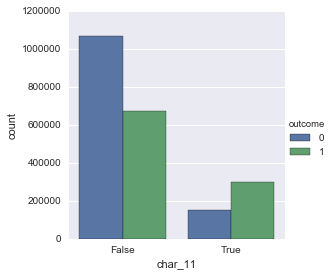

In [103]:
#char_11 and outcome
sns.factorplot("char_11", hue="outcome", data=raw_merge, kind="count")

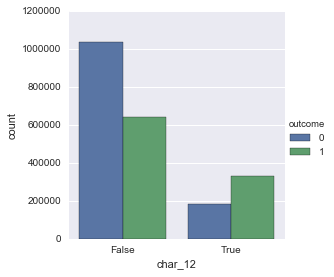

In [104]:
#char_12 and outcome
sns.factorplot("char_12", hue="outcome", data=raw_merge, kind="count")

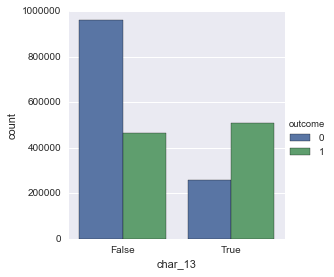

In [106]:
#char_13 and outcome
sns.factorplot("char_13", hue="outcome", data=raw_merge, kind="count")

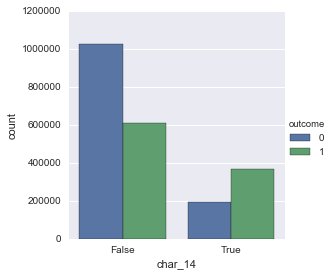

In [107]:
#char_14 and outcome
sns.factorplot("char_14", hue="outcome", data=raw_merge, kind="count")

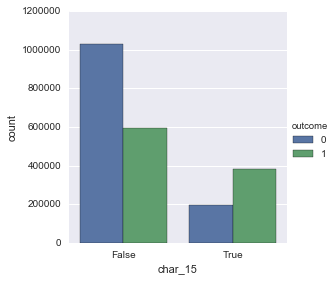

In [59]:
#char_15 and outcome
sns.factorplot("char_15", hue="outcome", data=raw_merge, kind="count")

- char_38

Char_38 is unique since it is a float variable.I also would like to see its distribution across outcome.

In [111]:
raw_merge.char_38.describe()

count    2.197291e+06
mean     4.998051e+01
std      3.608557e+01
min      0.000000e+00
25%      0.000000e+00
50%      5.900000e+01
75%      8.200000e+01
max      1.000000e+02
Name: char_38, dtype: float64

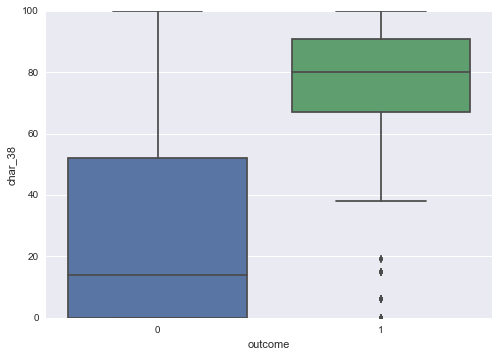

In [112]:
#see day differences distribution with respect to date_people
sns.boxplot(raw_merge.char_38, groupby = raw_merge.outcome)

Without doubts, distributions are different between two groups. char_38 in group 0 distributes relatively lower than they do in group 1. 

## Data reshaping and tranformation
### Rescaling

As I mentioned previously, absolute values of date_trian and date_people are too large compared to most of others distributing between 0 and 1, like boolean variables.

Although tree-based models does not require rescaling, I still rescaled them for convinience. The rescaling method is min-max-scale. 

In [10]:
#min max scale three variables, date_train, date_people and char_38
def min_max_scale(dataset, column):
    minmaxscaler = MinMaxScaler()
    char_38 = dataset[column]
    char_38_scale = minmaxscaler.fit_transform(char_38)
    char_38 = pd.Series(char_38_scale)
    dataset[column] = char_38

    return dataset

raw_merge_scaler = raw_merge
test_merge_scaler = test_merge
scaler_list = ['date_train','date_people','char_38']
for item in scaler_list:
    raw_merge_scaler = min_max_scale(raw_merge_scaler, item)
    test_merge_scaler = min_max_scale(test_merge_scaler, item)

C:\Users\fretwan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\fretwan\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\fretwan\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\fretwan\Anaconda2\lib\site-pa

### Cleaning and reshaping

First of all, some redundant variables can be deleted. The couple of variables, people_id and activity_id, are not valid information. Char_1_x....char_9_x have been analyzed before that they have over 90% NAs so that we can only group them by whether they are NA or not. A new variable, na_flag, has already been created. Besides, several variables, like date_x, have already been converted into other more effective format, so they can also be deleted.

In this case, we could divide them into y, with only outcomes, and x with all other valid information. 

In [11]:
#drop_list for x
drop_list = ['outcome','people_id','char_1_x','char_2_x','char_3_x','char_4_x','char_5_x','char_6_x','char_7_x'\
            ,'char_8_x','char_9_x','activity_id','date_x','date_y']
#create x and y
y_all = raw_merge_scaler['outcome']
x_all = raw_merge_scaler.drop(drop_list, axis = 1)

In [12]:
drop_list = ['people_id','activity_id','date_x','char_1_x','char_2_x','char_3_x','char_4_x','char_5_x','char_6_x','char_7_x'\
            ,'char_8_x','char_9_x','date_y']
pred_x_all = test_merge_scaler.drop(drop_list,axis = 1)

Next I am gonna cope with variables in objective type. Char_1_y.....char_9_y, and char_10_x are my major target. Around 6% of char_10_x are NA, which is within the acceptable range. So I would convert NA value into type 0, a normal type. Since char_1_y,....char_9_y do not have NAs, I plan to encode them with one hot encoder. 

Boolean data is also converted into numbers, true into 1 and false into 0. 

As a result, we expanded the variable list to over 30,000. 

In the process of one hot encoding, I came through splitting the data set into training set and testing set with straight shuffle split, which will be used in cross validation. 

In [13]:
#get the object and the not object list
object_list = []
not_object_list = []

for col, col_data in x_all.iteritems():
    #fill na with 'type 0
    x_all[col].fillna('type 0', inplace = True)
    if col_data.dtype == object:
        object_list.append(col)
    else :
        not_object_list.append(col)

In [14]:
le = LabelEncoder()

#create a function to convert, like "type 9" into interger 9, FALSE into 0, NA into 0
def convert_value(X):
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)
    
    #iterate each column
    for col, col_data in X.iteritems():
        #process only categorical data, not int data
        if col_data.dtype == object:
            #fill na with 'type 0
            col_data.fillna('type 0',inplace = True)
            le.fit(col_data)
            col_data = le.transform(col_data)
        elif col_data.dtype == bool:
            col_data = col_data+0
        
        output[col] = col_data
    return output
        

x_all_mod = convert_value(x_all)

In [15]:
pred_x_all_mod = convert_value(pred_x_all)

In [16]:
#split training set into training and testing group for cross validation
sss = StratifiedShuffleSplit(y_all, 3, test_size=0.3,random_state = 0)

In [17]:
for train_index, test_index in sss:
    X_train, X_test = x_all_mod.iloc[train_index], x_all_mod.iloc[test_index]
    Y_train, Y_test = y_all[train_index], y_all[test_index]

In [18]:
#one hot encode categorical variables for train set and test set.
enc = OneHotEncoder()
enc.fit(pd.concat([X_train[object_list],X_test[object_list]]))
X_train_sparse = enc.transform(X_train[object_list])
X_test_sparse = enc.transform(X_test[object_list])

In [19]:
test_X_sparse = enc.transform(pred_x_all_mod[object_list])

In [20]:
#get sparse matrix for training and testing set, respectively.
X_train_sp = hstack((X_train[not_object_list], X_train_sparse))
X_test_sp = hstack((X_test[not_object_list],X_test_sparse))

In [21]:
X_sparse = vstack([X_train_sp, X_test_sp])
y = Y_train.append(Y_test)

In [22]:
test_sp = hstack((pred_x_all_mod[not_object_list], test_X_sparse))

In [23]:
del X_train_sparse, X_test_sparse, test_X_sparse

## Learning and predicting
### Training and cross validation

I am gonna use xgboost to train the dataset at first. Xgboost is a tree-based model, so it is suitable to use it under the classification issue. Also, it has the function of self-impoving by boosting, that is really good to improving its performance. It is also fast and efficient and simple. 

In [25]:
dtrain = xgb.DMatrix(X_train_sp,label=Y_train)
dtrain_y = xgb.DMatrix(Y_train)
dtest = xgb.DMatrix(X_test_sp)
dtest_y = xgb.DMatrix(Y_test)

In [26]:
dtest_tp_pred = xgb.DMatrix(test_sp)

In [29]:
param = {'max_depth':15, 'eta':0.15, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['subsample'] = 0.7
param['colsample_bytree']= 0.7
param['min_child_weight'] = 0
param['booster'] = "gbtree"

watchlist  = [(dtrain,'train')]
num_round = 50
early_stopping_rounds=8
bst = xgb.train(param, dtrain, num_round, watchlist,early_stopping_rounds=early_stopping_rounds)

y_pred = bst.predict(dtest)

[0]	train-auc:0.929358
Will train until train-auc hasn't improved in 8 rounds.
[1]	train-auc:0.935877
[2]	train-auc:0.941283
[3]	train-auc:0.943469
[4]	train-auc:0.945456
[5]	train-auc:0.946929
[6]	train-auc:0.95028
[7]	train-auc:0.952291
[8]	train-auc:0.95354
[9]	train-auc:0.955662
[10]	train-auc:0.956568
[11]	train-auc:0.959141
[12]	train-auc:0.960767
[13]	train-auc:0.962881
[14]	train-auc:0.963628
[15]	train-auc:0.964236
[16]	train-auc:0.965445
[17]	train-auc:0.965921
[18]	train-auc:0.966097
[19]	train-auc:0.966501
[20]	train-auc:0.966792
[21]	train-auc:0.967256
[22]	train-auc:0.967989
[23]	train-auc:0.968316
[24]	train-auc:0.968819
[25]	train-auc:0.968964
[26]	train-auc:0.969184
[27]	train-auc:0.969412
[28]	train-auc:0.969838
[29]	train-auc:0.969924
[30]	train-auc:0.969958
[31]	train-auc:0.970105
[32]	train-auc:0.970278
[33]	train-auc:0.970385
[34]	train-auc:0.970511
[35]	train-auc:0.970615
[36]	train-auc:0.970732
[37]	train-auc:0.970858
[38]	train-auc:0.970942
[39]	train-auc:0.971

### Prediction and performances

In the following parts, I will get the prediction of testing groups. 

Then I will show the confusion matrix of, directly showing the number of True False, True Truth, Flase False and False Truth.

Next I will calculate the f1-score for testing set and draw the ROC curve.

In [30]:
to_pred2 = bst.predict(dtest_tp_pred)
to_pred2 = np.round(to_pred2)

In [31]:
y_P = np.array(y_pred)
y_pred_1 = np.round(y_P)

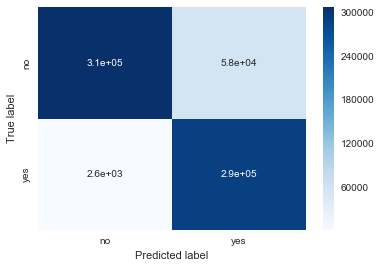

In [32]:
cm = confusion_matrix(Y_test, y_pred_1)

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [47]:
recall = recall_score(Y_test, y_pred_1)
precision = precision_score(Y_test, y_pred_1)
accuracy = accuracy_score(Y_test, y_pred_1)
print "recall is {}, precision is {} and accuracy is {}".format(recall, precision, accuracy)

recall is 0.991197646327, precision is 0.8326291255 and accuracy is 0.90763636474


In [35]:
f1_score = f1_score(Y_test, y_pred_1)
auc_test_score = roc_auc_score(Y_test, y_pred_1)
print "f1 score for test set is {}".format(f1_score)
print "auc score for test set is {}".format(auc_test_score)

f1 score for test set is 0.905020194031
auc score for test set is 0.916058856066


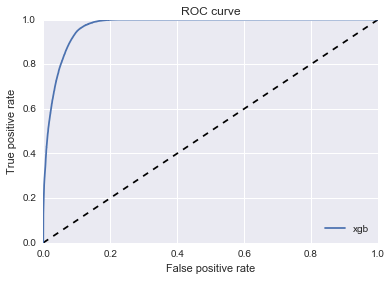

In [48]:
fpr_xgb, tpr_xgb, _ = roc_curve(Y_test, y_P)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, label='xgb')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

F1 score and auc score are around 0.9. Recall for 1 is 99.1%, while precision for 1 is 83.3%. Total accuracy is 90.76%. Though it is not bad for a first-time predicting, there is space to impove its performance. 

### Ensemble

Ensembling is a good way to improve performance. Following parts will show the ensembling process. I choose svm, random forest and logistic regression as base models, which are all good tree based algorithm, even though logistic regression is not suitable for thousand-variable data sets. Then I will use xgboost as the stacker classification. 

In [49]:
#create ensemble function
def ensemble(base_models, stacker, nfold, X, y, to_pred):
    X = X.tocsr()
    to_pred = to_pred.tocsr()
    
    folds = list(KFold(len(raw_merge), n_folds = nfold, shuffle = True, random_state = 0))
    pred_storage = np.zeros((len(raw_merge),len(base_models)))
    to_pred_storage = np.zeros((len(raw_test), len(base_models)))
    
    for i, clf in enumerate(base_models):
        to_pred_temp = np.zeros((len(raw_test), nfold))
        
        for j, (train_index, test_index) in enumerate(folds):
            X_train = X[train_index,:]
            y_train = y[train_index]
            X_test = X[test_index,:]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            pred_storage[test_index,i] = y_pred
            to_pred_temp[:,j] = clf.predict(to_pred)
        to_pred_storage[:,i] = to_pred_temp.mean(1)
    
    stacker.fit(pred_storage, y)
    outcome = stacker.predict(to_pred_storage)
    
    return outcome
            
    

In [50]:
gbc = GradientBoostingClassifier(random_state = 0, n_estimators = 30)
rfc = RandomForestClassifier(random_state = 0)
lgr = LogisticRegression(max_iter = 50, random_state = 0, solver = 'sag')
etc = ExtraTreesClassifier(random_state = 0)
svm = SVC(random_state = 0)

param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param["eval_metric"] = "auc"
param['eta'] = 0.15
param['max_depth'] = 10

xgboost = xgb.XGBClassifier()

base_models = [svm, rfc, lgr]

In [ ]:
final_prediction = ensemble(base_models, xgboost, 4, X_sparse, y, test_sp)

## Conclusion

In this project, I explored red cap data set and tried to predict the outcome based on features. 

I did an exploratory analysis firstly, getting familiar with relationships between outcome and each variable, having finding some strong relationship with statistical methods. Then I expand variables from tens to thousands, mainly converting variables in object format with one hot encoder. Next I used xgboost to fit the data and got a good performance, with f1 score of 0.905, recall of 0.991 and precision of 0.833. I also used ensembling to further impove performance. 